# Chapter 2: Understanding g2o File Format

## 🎯 학습 목표

이 챕터에서는 Pose Graph Optimization에서 널리 사용되는 g2o (General Graph Optimization) 파일 포맷을 이해하고 파싱하는 방법을 배웁니다.

- g2o 파일 포맷의 구조 이해 (VERTEX와 EDGE)
- Information matrix의 역할과 중요성
- Python으로 g2o 파일 파서 구현
- 실제 데이터셋 로드 및 시각화
- g2o 파일 생성 및 활용

> 💡 **왜 g2o를 배워야 할까요?**
> g2o는 SLAM 커뮤니티의 "공용어"와 같습니다. 마치 웹 개발에서 JSON이 표준 데이터 형식인 것처럼, SLAM에서는 g2o가 pose graph를 표현하는 표준입니다. 다양한 SLAM 라이브러리(g2o, GTSAM, Ceres)들이 이 포맷을 지원하므로, g2o를 이해하면 어떤 SLAM 시스템에서도 작업할 수 있습니다.

## 📚 이론적 배경

### g2o가 해결하는 문제: "누적 오차의 악몽"

**실제 시나리오**: 로봇 청소기가 집안을 청소한다고 상상해보세요.

```
시작 → 거실(1m) → 부엌(2m) → 침실(3m) → 화장실(2m) → 거실로 돌아옴
```

- **문제**: 각 이동마다 5cm 오차 발생
- **누적 오차**: 5cm × 4회 = 20cm
- **결과**: 거실로 돌아왔을 때 로봇은 자신이 20cm 떨어진 곳에 있다고 생각함!

**g2o의 해결책**: 
- "거실로 돌아왔다"는 Loop Closure 정보를 활용
- 전체 경로를 재조정하여 오차를 분산
- 결과적으로 더 정확한 지도 생성

### g2o 파일 포맷의 구조

g2o는 그래프 구조로 SLAM 문제를 표현합니다:

```
    VERTEX (포즈)
       ↓
    [Pose 0] ----EDGE----> [Pose 1]
       |     (측정값)         |
       |                      |
    EDGE(Loop)             EDGE
       |                      |
       ↓                      ↓
    [Pose 3] <----EDGE---- [Pose 2]
```

### Information Matrix: "측정값에 대한 신뢰도"

**직관적 비유**: GPS vs 보폭 계산
- **GPS 측정**: 정확도 ±1m → Information 값 높음 (믿을만함)
- **보폭 계산**: 정확도 ±10cm/걸음 → Information 값 낮음 (덜 믿을만함)

**수학적 의미**:
- Information Matrix = Covariance Matrix의 역행렬
- 대각선 값이 클수록 = 해당 차원의 측정이 정확함
- 비대각선 값 = 차원 간 상관관계

**실제 영향**:
```python
# 높은 Information (정확한 측정)
info_high = [[1000, 0, 0],    # x 방향 매우 정확
             [0, 1000, 0],     # y 방향 매우 정확  
             [0, 0, 1000]]     # 회전 매우 정확

# 낮은 Information (부정확한 측정)
info_low = [[10, 0, 0],       # x 방향 불확실
            [0, 10, 0],        # y 방향 불확실
            [0, 0, 100]]       # 회전은 상대적으로 정확
```

## 🔧 필요한 라이브러리 임포트

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation
import os
from pathlib import Path

# Chapter 1에서 정의한 함수들
def quat_to_rotmat(qx, qy, qz, qw):
    rotation = Rotation.from_quat([qx, qy, qz, qw])
    return rotation.as_matrix()

def rotmat_to_rotvec(R):
    rotation = Rotation.from_matrix(R)
    rotvec = rotation.as_rotvec()
    return rotvec

def se2_to_se3(x, y, theta):
    """SE(2) → SE(3) 변환 (2D를 3D로 확장)"""
    rotation = Rotation.from_euler("z", theta)
    R = rotation.as_matrix()
    t = np.array([x, y, 0.0])
    return R, t

print("✅ 라이브러리 임포트 완료!")

✅ 라이브러리 임포트 완료!


## 1. g2o 파일 포맷 구조 상세

### 1.1 VERTEX 포맷: "로봇의 위치 기록하기"

#### SE(3) 포즈 (3D SLAM용):
```
VERTEX_SE3:QUAT id x y z qx qy qz qw
```

**예시와 설명**:
```
VERTEX_SE3:QUAT 0 1.5 2.3 0.1 0.0 0.0 0.707 0.707
```
- `id = 0`: 이 포즈의 고유 번호 (시간 순서나 키프레임 번호)
- `x=1.5, y=2.3, z=0.1`: 3D 위치 (미터 단위)
- `qx=0, qy=0, qz=0.707, qw=0.707`: Z축 중심 90도 회전 (쿼터니언)

**실제 사용 예**: 드론이 건물 내부를 매핑할 때

#### SE(2) 포즈 (2D SLAM용):
```
VERTEX_SE2 id x y theta
```

**예시와 설명**:
```
VERTEX_SE2 5 10.2 -3.7 1.57
```
- `id = 5`: 5번째 포즈
- `x=10.2, y=-3.7`: 2D 위치
- `theta=1.57`: 90도 회전 (라디안)

**실제 사용 예**: 로봇 청소기, 자율주행 휠체어

### 1.2 EDGE 포맷: "포즈 간의 관계"

#### SE(3) 엣지 (3D):
```
EDGE_SE3:QUAT id1 id2 dx dy dz dqx dqy dqz dqw info(21)
```

**예시와 설명**:
```
EDGE_SE3:QUAT 0 1 0.5 0.0 0.0 0.0 0.0 0.0 1.0 500 0 500 0 0 500 0 0 0 100 0 0 0 100 0 0 0 0 100
```
- `id1=0, id2=1`: 포즈 0에서 포즈 1로의 변환
- `dx=0.5`: X축으로 0.5m 이동
- `dqw=1.0`: 회전 없음 (항등 쿼터니언)
- `info(21)`: 6×6 Information matrix의 상삼각 부분 (21개 원소)

#### Information Matrix 상세 설명:

6×6 Information matrix는 다음과 같은 구조를 가집니다:
```
[x  y  z  roll pitch yaw]  <- 차원
 ↓
[a  b  c  d    e     f  ]  x
[   g  h  i    j     k  ]  y  
[      l  m    n     o  ]  z
[         p    q     r  ]  roll
[              s     t  ]  pitch
[                    u  ]  yaw
```

상삼각 형태로 저장: `[a b c d e f g h i j k l m n o p q r s t u]`

### 💡 초보자가 자주 하는 실수들

1. **ID 관리 실수**:
   ```
   # ❌ 잘못된 예: ID 중복
   VERTEX_SE2 1 0.0 0.0 0.0
   VERTEX_SE2 1 1.0 0.0 0.0  # ERROR: ID 1 중복!
   
   # ✅ 올바른 예
   VERTEX_SE2 1 0.0 0.0 0.0
   VERTEX_SE2 2 1.0 0.0 0.0
   ```

2. **존재하지 않는 노드 참조**:
   ```
   # ❌ 잘못된 예
   VERTEX_SE2 0 0.0 0.0 0.0
   VERTEX_SE2 1 1.0 0.0 0.0
   EDGE_SE2 0 5 1.0 0.0 0.0 ...  # ERROR: 노드 5가 없음!
   ```

3. **Information Matrix 스케일 문제**:
   ```python
   # ❌ 너무 큰 값
   info = np.diag([1e10, 1e10, 1e10])  # 수치적 불안정
   
   # ✅ 적절한 값
   info = np.diag([500, 500, 100])     # 위치는 정확, 회전은 덜 정확
   ```

4. **단위 불일치**:
   ```
   # ❌ 문제 상황
   VERTEX_SE2 0 0.0 0.0 0.0      # 미터 단위
   EDGE_SE2 0 1 100.0 0.0 0.0    # 센티미터 단위? 미터 단위?
   ```

### 🛠️ 실제 SLAM 시스템에서의 활용

1. **Visual SLAM (ORB-SLAM)**:
   - 키프레임마다 VERTEX 생성
   - 시각적 오도메트리로 EDGE 생성
   - 루프 감지 시 Loop Closure EDGE 추가

2. **LiDAR SLAM (LOAM)**:
   - 일정 거리/각도마다 VERTEX
   - Point cloud 매칭으로 EDGE
   - Information은 매칭 품질에 따라 조정

3. **Multi-Robot SLAM**:
   - 각 로봇의 궤적을 별도 g2o로 저장
   - 로봇 간 만남 시 Inter-robot EDGE 추가
   - 통합 최적화로 전체 지도 생성

## 2. g2o 파서 구현

이제 실제로 g2o 파일을 파싱하는 함수를 구현해봅시다.

In [2]:
class G2OParser:
    """g2o 파일 파서 클래스"""
    
    def __init__(self):
        self.poses = {}  # {id: {'R': rotation_matrix, 't': translation}}
        self.edges = []  # [{'from': id1, 'to': id2, 'R': R, 't': t, 'information': I}]
        self.dimension = None  # 2D or 3D
        
    def parse_information_matrix(self, data, size):
        """상삼각 행렬에서 전체 대칭 행렬 복원
        
        g2o는 information matrix를 상삼각 형태로 저장합니다.
        예: 3×3 행렬의 경우 [a, b, c, d, e, f] → [[a,b,c],[b,d,e],[c,e,f]]
        """
        information_upper = np.array(data, dtype=float)
        information_matrix = np.zeros((size, size))
        
        # 상삼각 원소를 행렬에 채우기
        indices = np.triu_indices(size)
        information_matrix[indices] = information_upper
        
        # 대칭 행렬 만들기 (대각선 제외)
        information_matrix = information_matrix + information_matrix.T - np.diag(information_matrix.diagonal())
        
        return information_matrix
    
    def parse_vertex_se3(self, data):
        """SE(3) vertex 파싱"""
        node_id = int(data[1])
        x, y, z = map(float, data[2:5])
        qx, qy, qz, qw = map(float, data[5:9])
        
        R = quat_to_rotmat(qx, qy, qz, qw)
        t = np.array([x, y, z])
        
        self.poses[node_id] = {'R': R, 't': t, 'r': rotmat_to_rotvec(R)}
        
    def parse_vertex_se2(self, data):
        """SE(2) vertex 파싱"""
        node_id = int(data[1])
        x, y, theta = map(float, data[2:5])
        
        R, t = se2_to_se3(x, y, theta)
        
        self.poses[node_id] = {'R': R, 't': t, 'r': rotmat_to_rotvec(R)}
        
    def parse_edge_se3(self, data):
        """SE(3) edge 파싱"""
        id_from = int(data[1])
        id_to = int(data[2])
        
        # 상대 변환
        x, y, z = map(float, data[3:6])
        qx, qy, qz, qw = map(float, data[6:10])
        
        R = quat_to_rotmat(qx, qy, qz, qw)
        t = np.array([x, y, z])
        
        # Information matrix (6×6)
        if len(data) >= 31:  # 10 + 21 elements
            info_data = list(map(float, data[10:31]))
            information = self.parse_information_matrix(info_data, 6)
        else:
            # 기본 information matrix
            information = np.eye(6)
            
        edge = {
            'from': id_from,
            'to': id_to,
            'R': R,
            't': t,
            'r': rotmat_to_rotvec(R),
            'information': information
        }
        self.edges.append(edge)
        
    def parse_edge_se2(self, data):
        """SE(2) edge 파싱"""
        id_from = int(data[1])
        id_to = int(data[2])
        
        # 상대 변환
        dx, dy, dtheta = map(float, data[3:6])
        R, t = se2_to_se3(dx, dy, dtheta)
        
        # Information matrix (3×3 → 6×6으로 확장)
        if len(data) >= 12:  # 6 + 6 elements for 3×3 matrix
            info_data_se2 = list(map(float, data[6:12]))
            info_se2 = self.parse_information_matrix(info_data_se2, 3)
            
            # SE(2) → SE(3) information matrix 확장
            information = np.eye(6)
            information[:2, :2] = info_se2[:2, :2]  # x, y
            information[5, 5] = info_se2[2, 2]      # theta → z rotation
        else:
            information = np.eye(6)
            
        edge = {
            'from': id_from,
            'to': id_to,
            'R': R,
            't': t,
            'r': rotmat_to_rotvec(R),
            'information': information
        }
        self.edges.append(edge)
    
    def parse_file(self, filename):
        """g2o 파일 파싱"""
        print(f"📂 파일 읽기: {filename}")
        
        with open(filename, 'r') as f:
            for line_num, line in enumerate(f, 1):
                data = line.strip().split()
                if not data:
                    continue
                    
                tag = data[0]
                
                try:
                    if tag == 'VERTEX_SE3:QUAT':
                        self.dimension = 3
                        self.parse_vertex_se3(data)
                    elif tag in ['VERTEX_SE2', 'VERTEX2']:
                        self.dimension = 2
                        self.parse_vertex_se2(data)
                    elif tag == 'EDGE_SE3:QUAT':
                        self.parse_edge_se3(data)
                    elif tag in ['EDGE_SE2', 'EDGE2']:
                        self.parse_edge_se2(data)
                except Exception as e:
                    print(f"⚠️  라인 {line_num} 파싱 오류: {e}")
                    print(f"    내용: {line.strip()}")
                    
        print(f"✅ 파싱 완료!")
        print(f"   - 포즈 수: {len(self.poses)}")
        print(f"   - 엣지 수: {len(self.edges)}")
        print(f"   - 차원: {self.dimension}D")
        
        return self.poses, self.edges

print("✅ G2OParser 클래스 정의 완료!")

✅ G2OParser 클래스 정의 완료!


## 3. 예제 g2o 파일 생성

실제 데이터를 파싱하기 전에, 간단한 예제 파일을 만들어 봅시다.

In [3]:
# 간단한 사각형 경로 g2o 파일 생성
example_g2o_content = """# Simple square path example
VERTEX_SE2 0 0.0 0.0 0.0
VERTEX_SE2 1 1.0 0.0 0.0
VERTEX_SE2 2 1.0 1.0 1.5708
VERTEX_SE2 3 0.0 1.0 3.1416
VERTEX_SE2 4 0.0 0.0 -1.5708

# Odometry edges
EDGE_SE2 0 1 1.0 0.0 0.0 500.0 0.0 500.0 0.0 0.0 500.0
EDGE_SE2 1 2 0.0 1.0 1.5708 500.0 0.0 500.0 0.0 0.0 500.0
EDGE_SE2 2 3 -1.0 0.0 1.5708 500.0 0.0 500.0 0.0 0.0 500.0
EDGE_SE2 3 4 0.0 -1.0 1.5708 500.0 0.0 500.0 0.0 0.0 500.0

# Loop closure edge
EDGE_SE2 4 0 0.0 0.0 0.0 700.0 0.0 700.0 0.0 0.0 700.0
"""

# 파일 저장
os.makedirs('data', exist_ok=True)
with open('data/simple_square.g2o', 'w') as f:
    f.write(example_g2o_content)
    
print("✅ 예제 g2o 파일 생성 완료: data/simple_square.g2o")

✅ 예제 g2o 파일 생성 완료: data/simple_square.g2o


## 4. g2o 파일 파싱 및 분석

In [4]:
# 파서 생성 및 파일 파싱
parser = G2OParser()
poses, edges = parser.parse_file('data/simple_square.g2o')

# 파싱 결과 분석
print("\n📊 파싱 결과 상세 분석:")
print("\n1. 포즈 정보:")
for pose_id, pose in sorted(poses.items()):
    print(f"   Pose {pose_id}:")
    print(f"     - 위치: {pose['t']}")
    print(f"     - 회전벡터: {pose['r']}")

print("\n2. 엣지 정보:")
for i, edge in enumerate(edges):
    edge_type = "Odometry" if abs(edge['from'] - edge['to']) == 1 else "Loop Closure"
    print(f"   Edge {i} ({edge_type}): {edge['from']} → {edge['to']}")
    print(f"     - 상대 이동: {edge['t']}")
    print(f"     - 상대 회전: {edge['r']}")
    print(f"     - Information matrix 대각합: {np.trace(edge['information']):.1f}")

📂 파일 읽기: data/simple_square.g2o
✅ 파싱 완료!
   - 포즈 수: 5
   - 엣지 수: 5
   - 차원: 2D

📊 파싱 결과 상세 분석:

1. 포즈 정보:
   Pose 0:
     - 위치: [0. 0. 0.]
     - 회전벡터: [0. 0. 0.]
   Pose 1:
     - 위치: [1. 0. 0.]
     - 회전벡터: [0. 0. 0.]
   Pose 2:
     - 위치: [1. 1. 0.]
     - 회전벡터: [0.     0.     1.5708]
   Pose 3:
     - 위치: [0. 1. 0.]
     - 회전벡터: [-0.         -0.         -3.14158531]
   Pose 4:
     - 위치: [0. 0. 0.]
     - 회전벡터: [-0.     -0.     -1.5708]

2. 엣지 정보:
   Edge 0 (Odometry): 0 → 1
     - 상대 이동: [1. 0. 0.]
     - 상대 회전: [0. 0. 0.]
     - Information matrix 대각합: 1003.0
   Edge 1 (Odometry): 1 → 2
     - 상대 이동: [0. 1. 0.]
     - 상대 회전: [0.     0.     1.5708]
     - Information matrix 대각합: 1003.0
   Edge 2 (Odometry): 2 → 3
     - 상대 이동: [-1.  0.  0.]
     - 상대 회전: [0.     0.     1.5708]
     - Information matrix 대각합: 1003.0
   Edge 3 (Odometry): 3 → 4
     - 상대 이동: [ 0. -1.  0.]
     - 상대 회전: [0.     0.     1.5708]
     - Information matrix 대각합: 1003.0
   Edge 4 (Loop Closure): 4 → 0
     -

## 5. Pose Graph 시각화

파싱한 데이터를 시각화해봅시다.

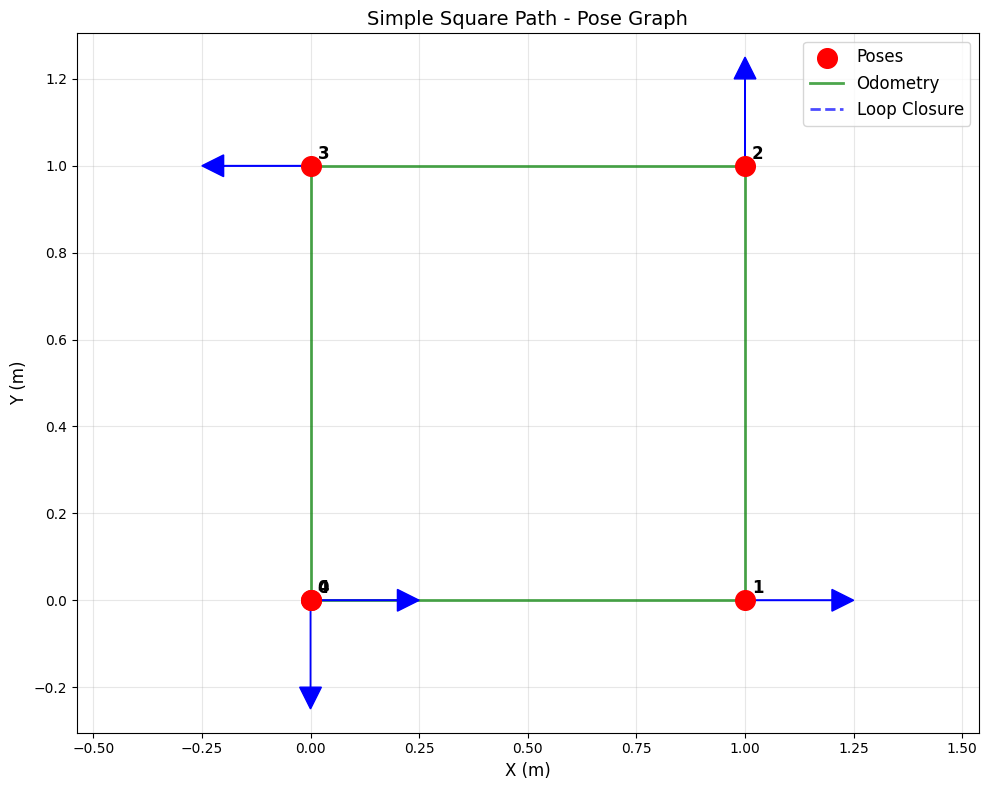

In [5]:
def visualize_pose_graph_2d(poses, edges, title="Pose Graph Visualization"):
    """2D Pose Graph 시각화"""
    plt.figure(figsize=(10, 8))
    
    # 포즈 위치 추출
    pose_ids = sorted(poses.keys())
    positions = np.array([poses[id]['t'][:2] for id in pose_ids])
    
    # 1. 포즈 그리기
    plt.scatter(positions[:, 0], positions[:, 1], 
                c='red', s=200, zorder=5, label='Poses')
    
    # 2. 포즈 ID 표시
    for i, pose_id in enumerate(pose_ids):
        plt.annotate(f'{pose_id}', 
                    (positions[i, 0], positions[i, 1]),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=12, fontweight='bold')
    
    # 3. 포즈 방향 표시 (화살표)
    for pose_id in pose_ids:
        pose = poses[pose_id]
        pos = pose['t'][:2]
        
        # 회전 행렬에서 방향 벡터 추출 (x축)
        direction = pose['R'][:2, 0] * 0.2  # 크기 조정
        
        plt.arrow(pos[0], pos[1], direction[0], direction[1],
                 head_width=0.05, head_length=0.05, 
                 fc='blue', ec='blue', zorder=4)
    
    # 4. 엣지 그리기
    for edge in edges:
        if edge['from'] in poses and edge['to'] in poses:
            pos1 = poses[edge['from']]['t'][:2]
            pos2 = poses[edge['to']]['t'][:2]
            
            # 엣지 타입별 색상
            if abs(edge['from'] - edge['to']) == 1:
                # Odometry edge
                plt.plot([pos1[0], pos2[0]], [pos1[1], pos2[1]], 
                        'g-', linewidth=2, alpha=0.7, label='Odometry' if edge == edges[0] else '')
            else:
                # Loop closure edge
                plt.plot([pos1[0], pos2[0]], [pos1[1], pos2[1]], 
                        'b--', linewidth=2, alpha=0.7, label='Loop Closure' if 'Loop' not in plt.gca().get_legend_handles_labels()[1] else '')
    
    plt.xlabel('X (m)', fontsize=12)
    plt.ylabel('Y (m)', fontsize=12)
    plt.title(title, fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

# 시각화
visualize_pose_graph_2d(poses, edges, "Simple Square Path - Pose Graph")

## 6. Information Matrix 분석

### 📊 Information Matrix가 최적화에 미치는 영향

Information Matrix는 단순한 숫자가 아닙니다. 이는 최적화 알고리즘에게 "어떤 측정을 더 믿어야 하는지"를 알려주는 중요한 정보입니다.

### 실제 예시로 이해하기

**시나리오**: 로봇이 어두운 터널을 지나가는 상황

1. **밝은 곳 (Visual SLAM 정확)**
   ```python
   # 카메라 특징점 많음, 정확한 측정
   info_bright = np.diag([1000, 1000, 1000, 500, 500, 500])
   # → "이 측정값을 매우 믿어도 됩니다"
   ```

2. **어두운 터널 (Visual SLAM 부정확)**
   ```python
   # 특징점 부족, 부정확한 측정
   info_dark = np.diag([10, 10, 10, 5, 5, 5])
   # → "이 측정값은 별로 믿지 마세요"
   ```

3. **IMU 보조 (회전만 정확)**
   ```python
   # IMU는 회전 측정에 강함
   info_imu = np.diag([10, 10, 10, 1000, 1000, 1000])
   # → "위치는 불확실하지만 회전은 정확합니다"
   ```

### Information Matrix의 조건수 (Condition Number)

조건수는 행렬의 "건강 상태"를 나타냅니다:

- **κ < 100**: 건강한 행렬 ✅
- **100 < κ < 1000**: 주의 필요 ⚠️
- **κ > 1000**: 수치적으로 불안정 ❌

**왜 중요한가?**
```python
# 나쁜 조건수의 예
info_bad = [[1e6, 0, 0],      # X: 과도하게 정확
            [0, 1, 0],         # Y: 매우 부정확
            [0, 0, 1e6]]       # Theta: 과도하게 정확

# 조건수 = 1e6 → 최적화 불안정!
```

이런 경우 최적화 알고리즘이:
- 수렴하지 못하거나
- 잘못된 해를 찾거나
- 수치 오버플로우 발생

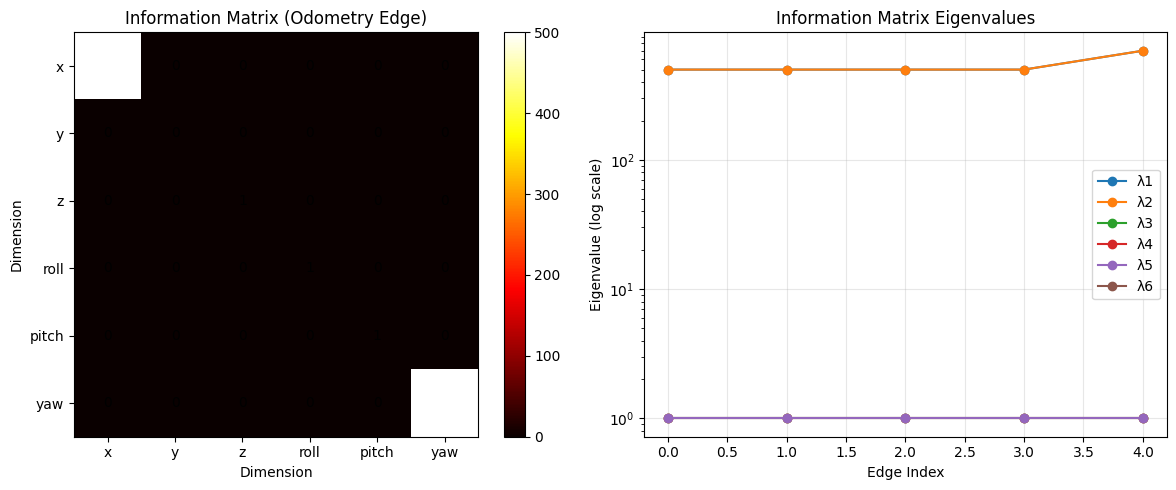


📊 Information Matrix 통계:

Edge 0 (Odometry):
  - 최대 고유값: 500.00
  - 최소 고유값: 0.00
  - 조건수 (κ): inf
  ⚠️  높은 조건수 - 수치적 불안정 가능성

Edge 1 (Odometry):
  - 최대 고유값: 500.00
  - 최소 고유값: 0.00
  - 조건수 (κ): inf
  ⚠️  높은 조건수 - 수치적 불안정 가능성

Edge 2 (Odometry):
  - 최대 고유값: 500.00
  - 최소 고유값: 0.00
  - 조건수 (κ): inf
  ⚠️  높은 조건수 - 수치적 불안정 가능성

Edge 3 (Odometry):
  - 최대 고유값: 500.00
  - 최소 고유값: 0.00
  - 조건수 (κ): inf
  ⚠️  높은 조건수 - 수치적 불안정 가능성

Edge 4 (Loop Closure):
  - 최대 고유값: 700.00
  - 최소 고유값: 0.00
  - 조건수 (κ): inf
  ⚠️  높은 조건수 - 수치적 불안정 가능성


/tmp/ipykernel_95790/2725444242.py:70: RuntimeWarning: divide by zero encountered in scalar divide
  print(f"  - 조건수 (κ): {eigvals[0]/eigvals[-1]:.2f}")
/tmp/ipykernel_95790/2725444242.py:73: RuntimeWarning: divide by zero encountered in scalar divide
  if eigvals[0]/eigvals[-1] > 1000:


In [6]:
def analyze_information_matrix(edges):
    """Information matrix 분석 및 시각화"""
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # 첫 번째 odometry edge의 information matrix
    odom_edge = edges[0]
    odom_info = odom_edge['information']
    
    # 1. Information matrix 히트맵
    ax1 = axes[0]
    im1 = ax1.imshow(odom_info, cmap='hot', interpolation='nearest')
    ax1.set_title('Information Matrix (Odometry Edge)', fontsize=12)
    ax1.set_xlabel('Dimension')
    ax1.set_ylabel('Dimension')
    
    # 축 라벨 추가
    dims = ['x', 'y', 'z', 'roll', 'pitch', 'yaw']
    ax1.set_xticks(range(6))
    ax1.set_yticks(range(6))
    ax1.set_xticklabels(dims)
    ax1.set_yticklabels(dims)
    
    # 값 표시
    for i in range(6):
        for j in range(6):
            text = ax1.text(j, i, f'{odom_info[i, j]:.0f}',
                           ha="center", va="center", color="white" if odom_info[i, j] > 250 else "black")
    
    plt.colorbar(im1, ax=ax1)
    
    # 2. 고유값 분석
    ax2 = axes[1]
    
    # 각 엣지의 information matrix 고유값 계산
    edge_types = []
    eigenvalues_list = []
    
    for edge in edges:
        eigvals = np.linalg.eigvals(edge['information'])
        eigenvalues_list.append(sorted(eigvals, reverse=True))
        
        if abs(edge['from'] - edge['to']) == 1:
            edge_types.append('Odometry')
        else:
            edge_types.append('Loop Closure')
    
    # 고유값 플롯
    eigenvalues_array = np.array(eigenvalues_list)
    x = range(len(edges))
    
    for i in range(6):
        ax2.semilogy(x, eigenvalues_array[:, i], 'o-', label=f'λ{i+1}')
    
    ax2.set_xlabel('Edge Index')
    ax2.set_ylabel('Eigenvalue (log scale)')
    ax2.set_title('Information Matrix Eigenvalues')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 통계 출력
    print("\n📊 Information Matrix 통계:")
    for i, (edge, eigvals) in enumerate(zip(edges, eigenvalues_list)):
        edge_type = edge_types[i]
        print(f"\nEdge {i} ({edge_type}):")
        print(f"  - 최대 고유값: {eigvals[0]:.2f}")
        print(f"  - 최소 고유값: {eigvals[-1]:.2f}")
        print(f"  - 조건수 (κ): {eigvals[0]/eigvals[-1]:.2f}")
        
        # 조건수가 크면 행렬이 ill-conditioned
        if eigvals[0]/eigvals[-1] > 1000:
            print(f"  ⚠️  높은 조건수 - 수치적 불안정 가능성")

# Information matrix 분석
analyze_information_matrix(edges)

## 7. 실제 데이터셋 다루기

이제 nano-pgo의 실제 데이터셋을 로드해봅시다.

In [7]:
# nano-pgo 데이터셋 경로 확인
data_path = Path("../data")
if data_path.exists():
    print("📁 사용 가능한 데이터셋:")
    for file in sorted(data_path.glob("*.g2o")):
        file_size = file.stat().st_size / 1024  # KB
        print(f"   - {file.name} ({file_size:.1f} KB)")
    
    for file in sorted(data_path.glob("*.graph")):
        file_size = file.stat().st_size / 1024  # KB
        print(f"   - {file.name} ({file_size:.1f} KB)")
else:
    print("⚠️  데이터 디렉토리를 찾을 수 없습니다.")
    print("   nano-pgo/data 디렉토리에 데이터셋이 있는지 확인하세요.")

📁 사용 가능한 데이터셋:
   - cubicle.g2o (2624.1 KB)
   - grid3D.g2o (7466.6 KB)
   - input_INTEL_g2o.g2o (211.3 KB)
   - input_M3500_g2o.g2o (710.8 KB)
   - input_M3500b_g2o.g2o (707.3 KB)
   - input_MITb_g2o.g2o (118.6 KB)
   - parking-garage.g2o (1251.1 KB)
   - rim.g2o (4743.6 KB)
   - sphere2500.g2o (1069.1 KB)
   - sphere_bignoise_vertex3.g2o (2169.6 KB)
   - torus3D.g2o (3186.4 KB)
   - CSAIL_P_toro.graph (162.8 KB)
   - FR079_P_toro.graph (164.8 KB)
   - FRH_P_toro.graph (337.8 KB)
   - M10000_P_toro.graph (7171.7 KB)



🔍 INTEL 데이터셋 파싱 중...
📂 파일 읽기: ../data/input_INTEL_g2o.g2o
✅ 파싱 완료!
   - 포즈 수: 1228
   - 엣지 수: 1483
   - 차원: 2D

📊 INTEL 데이터셋 통계:

엣지 타입별 분포:
  - Odometry edges: 1227 (82.7%)
  - Loop closure edges: 256 (17.3%)

경로 정보:
  - 총 이동 거리: 504.2 m
  - 평균 포즈 간격: 0.41 m

🎨 처음 100개 포즈 시각화...


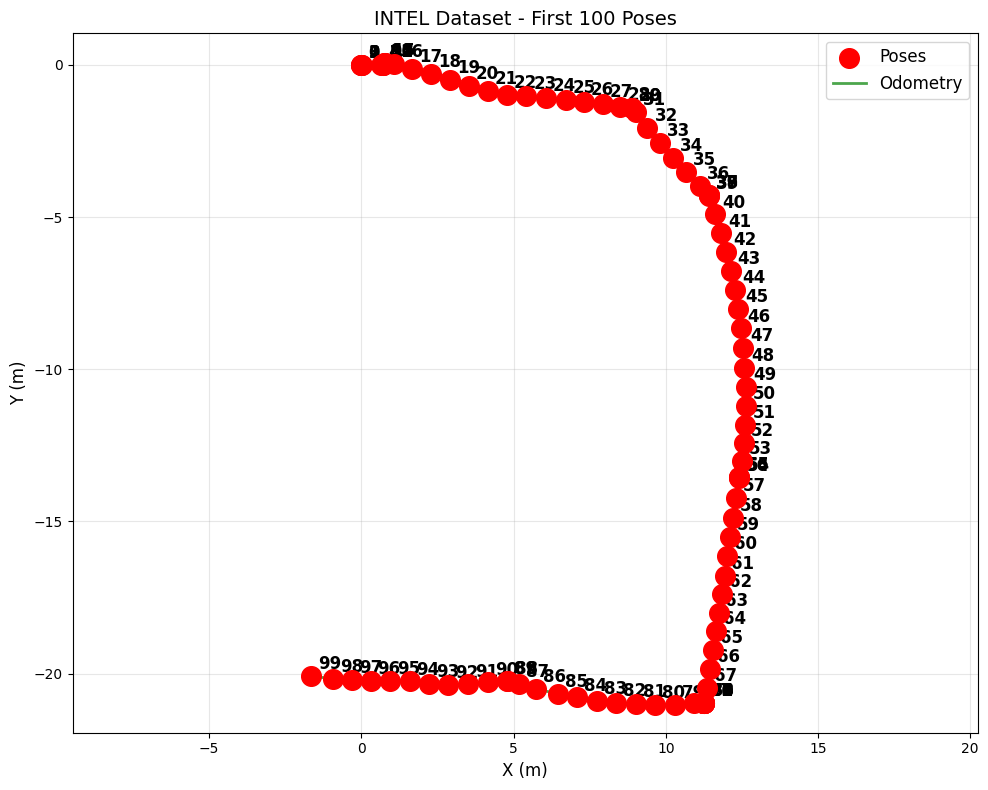

In [8]:
# 실제 데이터셋 파싱 (예: INTEL dataset)
if (data_path / "input_INTEL_g2o.g2o").exists():
    print("\n🔍 INTEL 데이터셋 파싱 중...")
    
    intel_parser = G2OParser()
    intel_poses, intel_edges = intel_parser.parse_file(str(data_path / "input_INTEL_g2o.g2o"))
    
    # 데이터셋 통계
    print("\n📊 INTEL 데이터셋 통계:")
    
    # 엣지 타입별 분류
    odom_edges = [e for e in intel_edges if abs(e['from'] - e['to']) == 1]
    loop_edges = [e for e in intel_edges if abs(e['from'] - e['to']) > 1]
    
    print(f"\n엣지 타입별 분포:")
    print(f"  - Odometry edges: {len(odom_edges)} ({len(odom_edges)/len(intel_edges)*100:.1f}%)")
    print(f"  - Loop closure edges: {len(loop_edges)} ({len(loop_edges)/len(intel_edges)*100:.1f}%)")
    
    # 경로 길이 계산
    total_distance = 0
    sorted_poses = sorted(intel_poses.items())
    for i in range(len(sorted_poses) - 1):
        pos1 = sorted_poses[i][1]['t']
        pos2 = sorted_poses[i+1][1]['t']
        total_distance += np.linalg.norm(pos2 - pos1)
    
    print(f"\n경로 정보:")
    print(f"  - 총 이동 거리: {total_distance:.1f} m")
    print(f"  - 평균 포즈 간격: {total_distance / (len(intel_poses)-1):.2f} m")
    
    # 부분 시각화 (전체는 너무 복잡함)
    print("\n🎨 처음 100개 포즈 시각화...")
    subset_poses = {k: v for k, v in intel_poses.items() if k < 100}
    subset_edges = [e for e in intel_edges if e['from'] < 100 and e['to'] < 100]
    
    visualize_pose_graph_2d(subset_poses, subset_edges, "INTEL Dataset - First 100 Poses")
else:
    print("⚠️  INTEL 데이터셋을 찾을 수 없습니다.")

## 8. g2o 파일 생성하기

파싱뿐만 아니라 g2o 파일을 생성하는 방법도 알아봅시다.

✅ g2o 파일 생성 완료: data/circular_path.g2o
📂 파일 읽기: data/circular_path.g2o
✅ 파싱 완료!
   - 포즈 수: 30
   - 엣지 수: 32
   - 차원: 2D


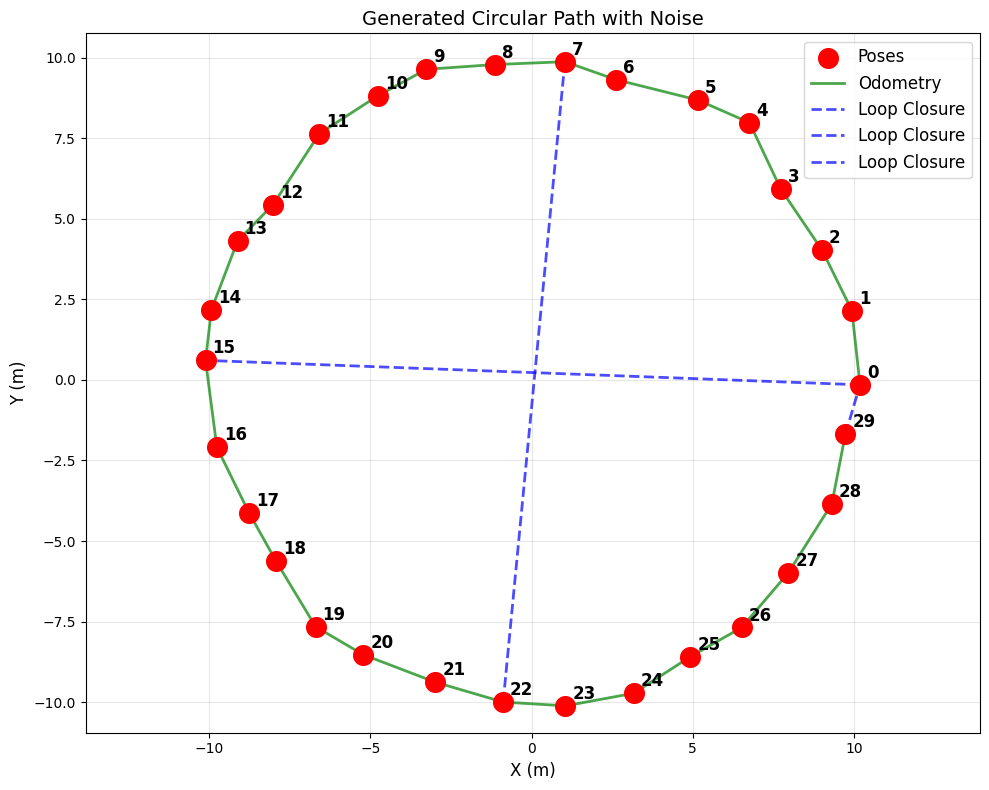

In [9]:
class G2OWriter:
    """g2o 파일 작성 클래스"""
    
    @staticmethod
    def write_vertex_se3(f, node_id, position, quaternion):
        """SE(3) vertex 작성"""
        x, y, z = position
        qx, qy, qz, qw = quaternion
        f.write(f"VERTEX_SE3:QUAT {node_id} {x:.6f} {y:.6f} {z:.6f} {qx:.6f} {qy:.6f} {qz:.6f} {qw:.6f}\n")
    
    @staticmethod
    def write_vertex_se2(f, node_id, x, y, theta):
        """SE(2) vertex 작성"""
        f.write(f"VERTEX_SE2 {node_id} {x:.6f} {y:.6f} {theta:.6f}\n")
    
    @staticmethod
    def write_edge_se3(f, id1, id2, translation, quaternion, information):
        """SE(3) edge 작성"""
        dx, dy, dz = translation
        dqx, dqy, dqz, dqw = quaternion
        
        # Information matrix의 상삼각 부분 추출
        info_upper = information[np.triu_indices(6)]
        info_str = ' '.join([f"{val:.6f}" for val in info_upper])
        
        f.write(f"EDGE_SE3:QUAT {id1} {id2} {dx:.6f} {dy:.6f} {dz:.6f} ")
        f.write(f"{dqx:.6f} {dqy:.6f} {dqz:.6f} {dqw:.6f} {info_str}\n")
    
    @staticmethod
    def create_circular_path_g2o(filename, num_poses=20, radius=5.0, noise_std=0.1):
        """원형 경로 g2o 파일 생성 (노이즈 포함)"""
        with open(filename, 'w') as f:
            f.write("# Circular path with noise\n")
            
            # 1. Vertices 생성
            true_poses = []
            for i in range(num_poses):
                angle = 2 * np.pi * i / num_poses
                
                # 실제 위치
                true_x = radius * np.cos(angle)
                true_y = radius * np.sin(angle)
                true_theta = angle + np.pi/2  # 접선 방향
                
                # 노이즈 추가
                x = true_x + np.random.normal(0, noise_std)
                y = true_y + np.random.normal(0, noise_std)
                theta = true_theta + np.random.normal(0, noise_std/radius)
                
                true_poses.append((true_x, true_y, true_theta))
                G2OWriter.write_vertex_se2(f, i, x, y, theta)
            
            f.write("\n")
            
            # 2. Odometry edges
            odom_info = np.diag([500.0, 500.0, 500.0])  # 높은 신뢰도
            
            for i in range(num_poses):
                j = (i + 1) % num_poses
                
                # 상대 변환 계산
                dx = true_poses[j][0] - true_poses[i][0]
                dy = true_poses[j][1] - true_poses[i][1]
                dtheta = true_poses[j][2] - true_poses[i][2]
                
                # 각도 정규화 [-π, π]
                while dtheta > np.pi: dtheta -= 2*np.pi
                while dtheta < -np.pi: dtheta += 2*np.pi
                
                # 로컬 좌표계로 변환
                cos_theta = np.cos(true_poses[i][2])
                sin_theta = np.sin(true_poses[i][2])
                dx_local = cos_theta * dx + sin_theta * dy
                dy_local = -sin_theta * dx + cos_theta * dy
                
                # 노이즈 추가
                dx_local += np.random.normal(0, noise_std/2)
                dy_local += np.random.normal(0, noise_std/2)
                dtheta += np.random.normal(0, noise_std/(2*radius))
                
                # Edge 작성
                info_upper = odom_info[np.triu_indices(3)]
                info_str = ' '.join([f"{val:.1f}" for val in info_upper])
                
                f.write(f"EDGE_SE2 {i} {j} {dx_local:.6f} {dy_local:.6f} {dtheta:.6f} {info_str}\n")
            
            f.write("\n")
            
            # 3. Loop closure edges
            loop_info = np.diag([700.0, 700.0, 700.0])  # 더 높은 신뢰도
            
            # 몇 개의 loop closure 추가
            loop_pairs = [
                (0, num_poses//2),
                (num_poses//4, 3*num_poses//4),
            ]
            
            for i, j in loop_pairs:
                if j < num_poses:
                    dx = true_poses[j][0] - true_poses[i][0]
                    dy = true_poses[j][1] - true_poses[i][1]
                    dtheta = true_poses[j][2] - true_poses[i][2]
                    
                    # 각도 정규화
                    while dtheta > np.pi: dtheta -= 2*np.pi
                    while dtheta < -np.pi: dtheta += 2*np.pi
                    
                    # 로컬 좌표계로 변환
                    cos_theta = np.cos(true_poses[i][2])
                    sin_theta = np.sin(true_poses[i][2])
                    dx_local = cos_theta * dx + sin_theta * dy
                    dy_local = -sin_theta * dx + cos_theta * dy
                    
                    # Loop closure는 더 많은 노이즈
                    dx_local += np.random.normal(0, noise_std)
                    dy_local += np.random.normal(0, noise_std)
                    dtheta += np.random.normal(0, noise_std/radius)
                    
                    info_upper = loop_info[np.triu_indices(3)]
                    info_str = ' '.join([f"{val:.1f}" for val in info_upper])
                    
                    f.write(f"EDGE_SE2 {i} {j} {dx_local:.6f} {dy_local:.6f} {dtheta:.6f} {info_str}\n")
        
        print(f"✅ g2o 파일 생성 완료: {filename}")

# 원형 경로 g2o 파일 생성
G2OWriter.create_circular_path_g2o('data/circular_path.g2o', num_poses=30, radius=10.0, noise_std=0.2)

# 생성된 파일 파싱 및 시각화
circular_parser = G2OParser()
circular_poses, circular_edges = circular_parser.parse_file('data/circular_path.g2o')
visualize_pose_graph_2d(circular_poses, circular_edges, "Generated Circular Path with Noise")

## 9. 요약 및 핵심 포인트

### 🎓 이 챕터에서 배운 내용:

1. **g2o 파일 포맷의 중요성**
   - SLAM 커뮤니티의 표준 데이터 형식
   - 다양한 라이브러리 간 호환성 제공
   - 누적 오차 문제를 체계적으로 표현

2. **VERTEX와 EDGE의 개념**
   - VERTEX: 로봇의 포즈 또는 랜드마크 위치
   - EDGE: 포즈 간 상대적 변환 (측정값)
   - SE(2)와 SE(3)의 차이점과 용도

3. **Information Matrix의 역할**
   - 측정의 신뢰도/정확도를 나타냄
   - 최적화 알고리즘의 가중치로 작용
   - 적절한 스케일 설정의 중요성

4. **파서 구현 기술**
   - 강건한 에러 처리
   - 다양한 포맷 지원 (SE2, SE3, TORO)
   - 효율적인 데이터 구조 설계

5. **실제 활용 방법**
   - 시각화를 통한 데이터 검증
   - Loop Closure의 중요성 이해
   - 노이즈가 있는 현실적인 데이터 생성

### 💡 실무 팁 정리

1. **디버깅 전략**
   - 항상 시각화로 데이터 확인
   - Information Matrix의 조건수 체크
   - 작은 데이터셋으로 먼저 테스트

2. **성능 최적화**
   - 불필요한 EDGE 제거 (거리가 먼 포즈 간)
   - Information Matrix 희소성 활용
   - 증분적 최적화 고려

3. **흔한 실수 방지**
   - ID 중복 체크 자동화
   - 단위 일관성 유지 (미터 vs 센티미터)
   - Information Matrix 양정치성 보장

### 🚀 다음 챕터 예고

다음 챕터에서는 **SymForce를 이용한 Symbolic Computation**을 배웁니다:
- 자동 미분의 마법
- Symbolic 표현의 장점
- 수동 미분 vs 자동 미분 성능 비교
- 실제 최적화 문제에 적용

### 📚 추가 학습 자료

- **g2o 공식 문서**: https://github.com/RainerKuemmerle/g2o
- **SLAM 데이터셋**: 
  - TUM RGB-D Dataset
  - KITTI Dataset
  - EuRoC MAV Dataset
- **관련 논문**:
  - "g2o: A General Framework for Graph Optimization" - Kümmerle et al.
  - "Information-theoretic selection of high-dimensional spectral features for structural recognition" - Colas et al.

### 🔑 핵심 메시지

> "g2o는 단순한 파일 포맷이 아닙니다. 이는 로봇의 불확실한 세계를 수학적으로 표현하는 언어입니다. VERTEX는 로봇의 '기억'이고, EDGE는 그 기억들 간의 '관계'이며, Information Matrix는 각 기억의 '신뢰도'입니다. 이 세 가지를 올바르게 이해하고 활용할 때, 비로소 정확한 SLAM이 가능해집니다."

## 🏋️ 연습 문제

### 문제 1: 3D g2o 파일 생성
나선형(helix) 경로를 따르는 3D g2o 파일을 생성하는 함수를 작성하세요.

### 문제 2: Information Matrix 실험
Information matrix의 값을 변경했을 때 최적화 결과가 어떻게 달라지는지 실험해보세요.

### 문제 3: 파일 변환기
TORO 포맷을 g2o 포맷으로 변환하는 함수를 작성하세요.

In [10]:
# 여기에 연습 문제를 풀어보세요!
# 예제 시작 코드:

# 문제 1: 3D 나선형 경로
def create_helix_path_g2o(filename, num_poses=50, radius=5.0, height=10.0):
    """3D 나선형 경로 생성"""
    # 여기에 구현하세요
    pass
